# Traffic Accidents analysis

## Dataset summary

The dataset to use in this exercise is "US Accidents (2016 - 2023)" by Sobhan Moosavi, which can be downloaded from Kaggle using this URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents.

This dataset contains information about traffic accidents in the United States from 2016 to 2023. It includes various features such as the date and time of the accident, location, weather conditions, and more.

In [1]:
import os

import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, weekday

C:\Users\danie\anaconda3\envs\env_pyspark\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading the dataset

We can leverage the kagglehub package to download the dataset directly from Kaggle. This package allows us to download datasets without needing to manually download them from the Kaggle website.

In [2]:
# Download the latest version
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\danie\.cache\kagglehub\datasets\sobhanmoosavi\us-accidents\versions\13


If you have already downloaded the dataset to your local machine, you can set the path to the dataset instead of using the kagglehub package. Uncomment the following line and set the path to your local dataset.

In [3]:
# path = "your-local-path"

This dataset contains a single CSV file named `US_Accidents_March23.csv`. This file contains the data we will be working with in this exercise. Update the path variable to point to this file.

In [4]:
dataset_path = path + "/US_Accidents_March23.csv"
print(f"Filesize of the dataset: {os.path.getsize(dataset_path) / (1024 * 1024 * 1024):.2f} GB")

Filesize of the dataset: 2.85 GB


## Loading the dataset with PySpark

The first thing we need to do is to create a PySpark session.

In [5]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("USTrafficAccidents") \
    .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

spark

We can now simply load the dataset into a PySpark dataframe:

In [6]:
# Lectura del dataset US Accidents con encabezado y detección automática de tipos de datos.
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

# Show the first 5 rows of the DataFrame
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

## Exploring the dataset

Now that the dataset is loaded, we can explore its contents. We can start by checking the schema of the DataFrame to understand the data types of each column.

In [7]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

We can also apply simple queries to get a better understanding of the data. For example, we can find the weather conditions with the most accidents.

In [8]:
df.groupBy("Weather_Condition") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(10, False)

+-----------------+-------+
|Weather_Condition|count  |
+-----------------+-------+
|Fair             |2560802|
|Mostly Cloudy    |1016195|
|Cloudy           |817082 |
|Clear            |808743 |
|Partly Cloudy    |698972 |
|Overcast         |382866 |
|Light Rain       |352957 |
|Scattered Clouds |204829 |
|NULL             |173459 |
|Light Snow       |128680 |
+-----------------+-------+
only showing top 10 rows



We can also do some basic data visualization. For example, we can plot a histogram with the number of accidents per time of day. For this, we extract the hour from the `Start_Time` column and group the data by hour. To make this easier, we execute the query using PySpark and convert the result to a Pandas DataFrame

In [9]:
by_hour = df.select(hour("Start_Time").alias("Hour")) \
    .groupBy("Hour") \
    .count() \
    .orderBy("Hour") \
    .toPandas()

by_hour

,Hour,count
0,0,112378
1,1,97071
2,2,93226
3,3,83864
4,4,159852
5,5,228182
6,6,405837
7,7,587472
8,8,577576
9,9,363034


<Axes: xlabel='Hour', ylabel='count'>

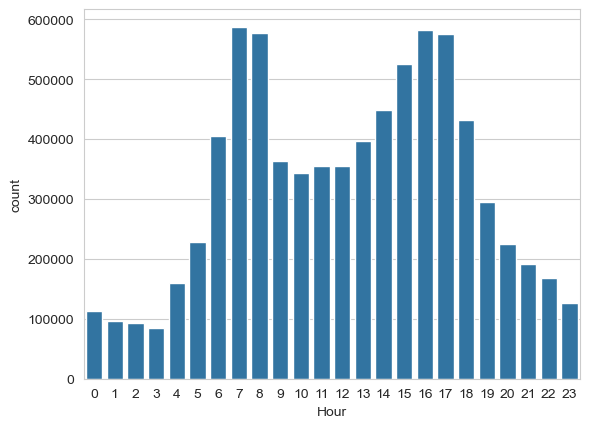

In [10]:
sns.barplot(data=by_hour, x="Hour", y="count")

We can even go further. For example, we can compare the number of accidents on weekdays and weekends. To do this, we can extract the weekday from the `Start_Time` column and group the data by weekday and hour.

In [11]:
by_day_hour = df.select(
    weekday("Start_Time").alias("Weekday"),
    hour("Start_Time").alias("Hour")) \
    .groupBy("Weekday", "Hour") \
    .count() \
    .orderBy("Weekday", "Hour") \
    .toPandas()

by_day_hour

,Weekday,Hour,count
0,0,0,13895
1,0,1,11676
2,0,2,11397
3,0,3,11316
4,0,4,26924
...,...,...,...
163,6,19,26534
164,6,20,23975
165,6,21,22922
166,6,22,19137


In [12]:
# Weekdays 5 and 6 are Saturday and Sunday, respectively
by_hour_workdays = by_day_hour.loc[by_day_hour["Weekday"] < 5] \
    .groupby("Hour") \
    .sum()

by_hour_weekends = by_day_hour.loc[by_day_hour["Weekday"] >= 5] \
    .groupby("Hour") \
    .sum()

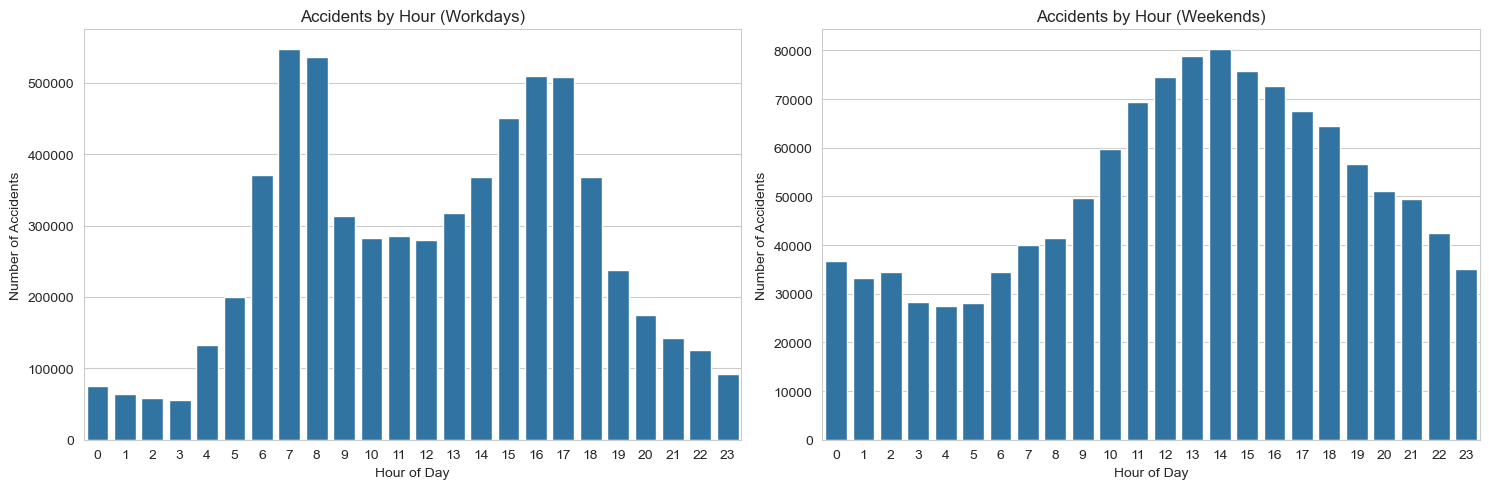

In [13]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot workdays
sns.barplot(data=by_hour_workdays, x="Hour", y="count", ax=ax1)
ax1.set_title("Accidents by Hour (Workdays)")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Number of Accidents")

# Plot weekends
sns.barplot(data=by_hour_weekends, x="Hour", y="count", ax=ax2)
ax2.set_title("Accidents by Hour (Weekends)")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Number of Accidents")

# Adjust layout to prevent overlap
plt.tight_layout()

In [14]:
count_by_severity = df.groupBy("Severity") \
    .count() \
    .orderBy("Severity") \
    .toPandas()

count_by_severity

,Severity,count
0,1,67366
1,2,6156981
2,3,1299337
3,4,204710


<Axes: xlabel='Severity', ylabel='count'>

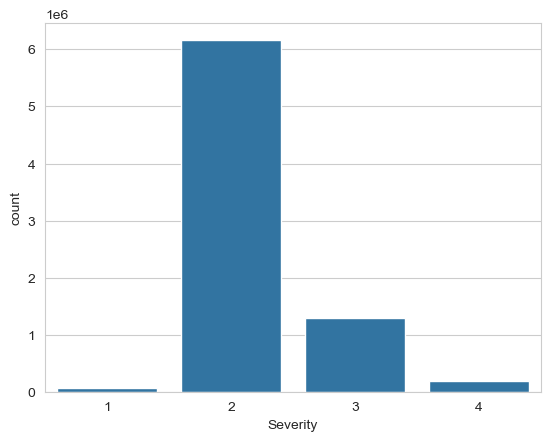

In [15]:
sns.barplot(data=count_by_severity, x="Severity", y="count")

In [16]:
count_by_sunrise_sunset = df.groupBy("Sunrise_Sunset") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas()

count_by_sunrise_sunset

,Sunrise_Sunset,count
0,Day,5334553
1,Night,2370595
2,None,23246


<Axes: xlabel='Sunrise_Sunset', ylabel='count'>

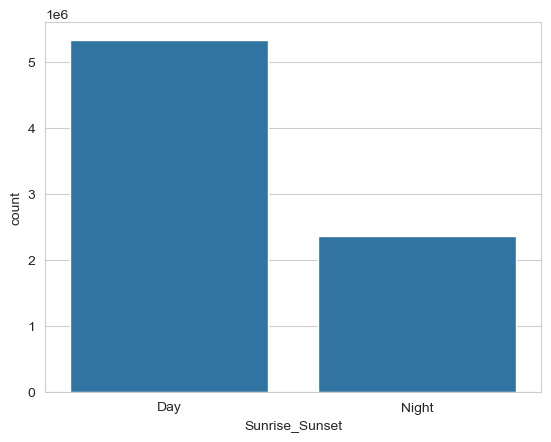

In [17]:
sns.barplot(data=count_by_sunrise_sunset, x="Sunrise_Sunset", y="count")

In [18]:
from pyspark.sql.functions import col, sum, when

# Para cada columna, sumamos 1 cuando el valor es nulo, y 0 en caso contrario
null_counts = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])

null_counts_pd = null_counts.toPandas().T
null_counts_pd.columns = ['Valores nulos']

null_counts_pd

,Valores nulos
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
End_Lat,3402762
End_Lng,3402762
Distance(mi),0


## Particionamiento

In [19]:
total_rows=df.count()
total_rows

7728394

In [20]:
# Calcular porcentaje
null_counts_pd['% de valores nulos'] = (null_counts_pd['Valores nulos'] / total_rows) * 100

# Filtrar columnas con nulos y ordenar
null_counts_pd = null_counts_pd[null_counts_pd['Valores nulos'] > 0]
null_counts_pd = null_counts_pd.sort_values('% de valores nulos', ascending=False)

# Mostrar resultado
null_counts_pd

,Valores nulos,% de valores nulos
End_Lat,3402762,44.029355
End_Lng,3402762,44.029355
Precipitation(in),2203586,28.512858
Wind_Chill(F),1999019,25.865904
Wind_Speed(mph),571233,7.391355
Visibility(mi),177098,2.291524
Wind_Direction,175206,2.267043
Humidity(%),174144,2.253301
Weather_Condition,173459,2.244438
Temperature(F),163853,2.120143


In [21]:
df.select("Weather_Condition") \
  .distinct() \
  .orderBy("Weather_Condition") \
  .show(truncate=False, n=1000)

+-----------------------------------+
|Weather_Condition                  |
+-----------------------------------+
|NULL                               |
|Blowing Dust                       |
|Blowing Dust / Windy               |
|Blowing Sand                       |
|Blowing Snow                       |
|Blowing Snow / Windy               |
|Blowing Snow Nearby                |
|Clear                              |
|Cloudy                             |
|Cloudy / Windy                     |
|Drifting Snow                      |
|Drifting Snow / Windy              |
|Drizzle                            |
|Drizzle / Windy                    |
|Drizzle and Fog                    |
|Dust Whirls                        |
|Duststorm                          |
|Fair                               |
|Fair / Windy                       |
|Fog                                |
|Fog / Windy                        |
|Freezing Drizzle                   |
|Freezing Rain                      |
|Freezing Ra

In [22]:
df.groupBy("Severity").count().withColumn("porcentaje", col("count") / df.count() * 100).show()

+--------+-------+------------------+
|Severity|  count|        porcentaje|
+--------+-------+------------------+
|       1|  67366|0.8716688098458748|
|       3|1299337| 16.81250981769304|
|       4| 204710|2.6488038782701815|
|       2|6156981|  79.6670174941909|
+--------+-------+------------------+



In [23]:
df = df.withColumn("Weather_Type",
    when(col("Weather_Condition").isNull(), "Desconocido")
    .when(col("Weather_Condition").rlike("(?i)null|N/A"), "Desconocido")
    .when(col("Weather_Condition").rlike("(?i)Rain|Drizzle|Thunder|Storm|Snow|Sleet|Hail|Ice|Fog|Haze|Mist|Dust|Sand|Smoke|Wintry|Squall|Tornado|Ash|Funnel"), "Adverso")
    .otherwise("Favorable")
)
df.groupBy("Weather_Type").count().withColumn("porcentaje", col("count") / df.count() * 100).show()

+------------+-------+------------------+
|Weather_Type|  count|        porcentaje|
+------------+-------+------------------+
| Desconocido| 176711|2.2865164483073714|
|     Adverso| 981225|12.696363565315123|
|   Favorable|6570458| 85.01711998637751|
+------------+-------+------------------+



In [24]:
from pyspark.sql.functions import hour

df = df.withColumn(
    "Hora_Periodo",
    when(hour("Start_Time") < 6, "Madrugada")
    .when(hour("Start_Time") < 18, "Alta actividad")
    .otherwise("Tarde-Noche")
)

df.groupBy("Hora_Periodo").count().withColumn("porcentaje", col("count") / df.count() * 100).show()

+--------------+-------+------------------+
|  Hora_Periodo|  count|        porcentaje|
+--------------+-------+------------------+
|   Tarde-Noche|1438025|18.607035303841908|
|Alta actividad|5515796| 71.37053312758123|
|     Madrugada| 774573| 10.02243156857686|
+--------------+-------+------------------+



In [25]:
from pyspark.sql.functions import date_format

# Paso 1: Extraer el día de la semana en formato abreviado (Mon, Tue, ..., Sun)
df = df.withColumn("Dia_Semana", date_format("Start_Time", "E"))

# Paso 2: Clasificar como "Laboral" o "Fin de semana"
df = df.withColumn(
    "Tipo_Día",
    when(col("Dia_Semana").isin("Sat", "Sun"), "Fin de semana").otherwise("Laboral")
)

# Paso 3: Calcular distribución porcentual
df.groupBy("Tipo_Día") \
  .count() \
  .withColumn("porcentaje", col("count") / df.count() * 100) \
  .show()

+-------------+-------+------------------+
|     Tipo_Día|  count|        porcentaje|
+-------------+-------+------------------+
|Fin de semana|1231427|15.933802029244367|
|      Laboral|6496967| 84.06619797075562|
+-------------+-------+------------------+



In [26]:
# Revisar ocurrencia de variables booleanas
variables_viales = ["Junction", "Crossing", "Traffic_Signal", "Amenity", "Bump", "Give_Way", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Turning_Loop"]

for var in variables_viales:
    df.groupBy(var) \
      .count() \
      .withColumn("porcentaje", col("count") / df.count() * 100) \
      .show()

+--------+-------+-----------------+
|Junction|  count|       porcentaje|
+--------+-------+-----------------+
|    true| 571342|7.392764913383039|
|   false|7157052|92.60723508661695|
+--------+-------+-----------------+

+--------+-------+------------------+
|Crossing|  count|        porcentaje|
+--------+-------+------------------+
|    true| 873763|11.305880626686477|
|   false|6854631| 88.69411937331353|
+--------+-------+------------------+

+--------------+-------+------------------+
|Traffic_Signal|  count|        porcentaje|
+--------------+-------+------------------+
|          true|1143772|14.799607783971677|
|         false|6584622| 85.20039221602832|
+--------------+-------+------------------+

+-------+-------+------------------+
|Amenity|  count|        porcentaje|
+-------+-------+------------------+
|   true|  96334|1.2464944204449204|
|  false|7632060| 98.75350557955508|
+-------+-------+------------------+

+-----+-------+--------------------+
| Bump|  count|        

In [27]:
from pyspark.sql.functions import count, round

# Paso 1: Filtrar registros válidos (sin valores nulos en variables clave)
df_filtrado = df.filter(
    (col("Severity").isNotNull()) &
    (col("Hora_Periodo").isNotNull()) &
    (col("Tipo_Día").isNotNull()) &
    (col("Weather_Type").isNotNull())
)

# Paso 2: Contar el total de registros filtrados
total_registros = df_filtrado.count()

# Paso 3: Agrupar por combinación de estratos y calcular frecuencia y probabilidad empírica
estratos = df_filtrado.groupBy("Severity", "Hora_Periodo", "Tipo_Día", "Weather_Type") \
    .agg(count("*").alias("frecuencia")) \
    .withColumn("probabilidad", round(col("frecuencia") / total_registros, 6)) \
    .orderBy(col("probabilidad").desc())

# Paso 4 (opcional): Mostrar tabla en consola
estratos.show(n=72, truncate=False)

# Paso 5 (opcional): Exportar a CSV para integrarlo al documento
estratos_pd = estratos.toPandas()
estratos_pd.to_csv("probabilidades_estratos.csv", index=False)

+--------+--------------+-------------+------------+----------+------------+
|Severity|Hora_Periodo  |Tipo_Día     |Weather_Type|frecuencia|probabilidad|
+--------+--------------+-------------+------------+----------+------------+
|2       |Alta actividad|Laboral      |Favorable   |3284990   |0.425055    |
|2       |Tarde-Noche   |Laboral      |Favorable   |769153    |0.099523    |
|3       |Alta actividad|Laboral      |Favorable   |668374    |0.086483    |
|2       |Alta actividad|Fin de semana|Favorable   |474374    |0.061381    |
|2       |Alta actividad|Laboral      |Adverso     |471166    |0.060966    |
|2       |Madrugada     |Laboral      |Favorable   |387436    |0.050132    |
|2       |Tarde-Noche   |Fin de semana|Favorable   |203195    |0.026292    |
|3       |Tarde-Noche   |Laboral      |Favorable   |172912    |0.022374    |
|2       |Madrugada     |Fin de semana|Favorable   |129078    |0.016702    |
|3       |Alta actividad|Fin de semana|Favorable   |125639    |0.016257    |

In [28]:
# from google.colab import files
# files.download("probabilidades_estratos.csv")

In [29]:
# Tamaño total de muestra deseado
tamanio_muestra_total = 10000

# Calcular n_estrato para cada combinación
estratos = estratos.withColumn(
    "n_estrato",
    round(col("probabilidad") * tamanio_muestra_total).cast("integer")
)

In [30]:
from pyspark.sql.functions import concat_ws

# En df_filtrado (base depurada sin nulos en variables clave)
df_filtrado = df_filtrado.withColumn(
    "estrato_id",
    concat_ws("_", "Severity", "Hora_Periodo", "Tipo_Día", "Weather_Type")
)

# Igual en la tabla de estratos con probabilidades y n_estrato
estratos = estratos.withColumn(
    "estrato_id",
    concat_ws("_", "Severity", "Hora_Periodo", "Tipo_Día", "Weather_Type")
)

In [31]:
# Join para agregar columna de tamaño muestral a cada registro según su estrato
df_muestreo = df_filtrado.join(
    estratos.select("estrato_id", "n_estrato"),
    on="estrato_id",
    how="inner"
)

In [32]:
from pyspark.sql.functions import rand
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Asignar un número aleatorio y calcular el orden por estrato
df_muestreo = df_muestreo.withColumn("rand", rand(seed=42))

window = Window.partitionBy("estrato_id").orderBy("rand")

df_muestreo = df_muestreo.withColumn("row_num", row_number().over(window))

In [33]:
# Seleccionar solo las filas dentro del tamaño asignado por estrato
df_muestra_final = df_muestreo.filter(col("row_num") <= col("n_estrato"))

In [34]:
from pyspark.sql.functions import count, col

# Paso 1: Contar observaciones extraídas por estrato en la muestra final
conteo_muestra = df_muestra_final.groupBy("estrato_id") \
    .agg(count("*").alias("observaciones_extraidas"))

# Paso 2: Unir con la tabla de tamaños esperados (n_estrato)
validacion = conteo_muestra.join(
    estratos.select("estrato_id", "n_estrato"),
    on="estrato_id",
    how="inner"
)

# Paso 3: Calcular diferencia entre lo observado y lo esperado
validacion = validacion.withColumn(
    "diferencia",
    col("observaciones_extraidas") - col("n_estrato")
)

# Mostrar resultados en consola
validacion.orderBy("diferencia").show(truncate=False)


+------------------------------------------+-----------------------+---------+----------+
|estrato_id                                |observaciones_extraidas|n_estrato|diferencia|
+------------------------------------------+-----------------------+---------+----------+
|1_Alta actividad_Fin de semana_Favorable  |3                      |3        |0         |
|1_Madrugada_Laboral_Adverso               |1                      |1        |0         |
|1_Alta actividad_Laboral_Adverso          |5                      |5        |0         |
|1_Madrugada_Laboral_Favorable             |8                      |8        |0         |
|1_Alta actividad_Laboral_Desconocido      |1                      |1        |0         |
|1_Tarde-Noche_Fin de semana_Favorable     |1                      |1        |0         |
|1_Alta actividad_Laboral_Favorable        |57                     |57       |0         |
|2_Alta actividad_Laboral_Favorable        |4251                   |4251     |0         |
|1_Madruga

In [35]:
validacion.filter(col("diferencia") < 0).orderBy("diferencia").show(truncate=False)

+----------+-----------------------+---------+----------+
|estrato_id|observaciones_extraidas|n_estrato|diferencia|
+----------+-----------------------+---------+----------+
+----------+-----------------------+---------+----------+



# References

- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.